______  ___     ______                        _________
___   |/  /________  /_______ _______ ______________  /
__  /|_/ /_  __ \_  __ \  __ `/_  __ `__ \  _ \  __  / 
_  /  / / / /_/ /  / / / /_/ /_  / / / / /  __/ /_/ /  
/_/  /_/  \____//_/ /_/\__,_/ /_/ /_/ /_/\___/\__,_/   
                                                       
_____________ _________      ___________        _________            
___    |__  /_______  /_____ ___  /__  /_______ ______  /____________
__  /| |_  __ \  __  /_  __ `/_  /__  //_/  __ `/  __  /_  _ \_  ___/
_  ___ |  /_/ / /_/ / / /_/ /_  / _  ,<  / /_/ // /_/ / /  __/  /    
/_/  |_/_.___/\__,_/  \__,_/ /_/  /_/|_| \__,_/ \__,_/  \___//_/     
                                                                     



## Import

In [2]:
# import necessary modules
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers

from keras.layers import Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading data

In [3]:
# Reading generated power (Solar and wind) data
# Dataset link : https://data.open-power-system-data.org/time_series/2020-10-06

df = pd.read_csv(
    r"C:\Users\Mohamed\OneDrive\Desktop\Graduation project\opsd-time_series-2020-10-06\time_series_60min_singleindex.csv",
                        usecols=(lambda s: s.startswith('utc') | s.startswith('DE')),
                        parse_dates=[0], index_col=0)

In [4]:
df.head()

,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,...,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,667.0,517.0,...,13841.0,13362.0,NaN,3866.0,469.0,3398.0,5307.0,4703.0,NaN,5.0
2015-01-01 01:00:00+00:00,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,667.0,514.0,...,13267.0,12858.0,NaN,3974.0,466.0,3508.0,5087.0,4562.0,NaN,7.0
2015-01-01 02:00:00+00:00,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,667.0,518.0,...,12702.0,12611.0,NaN,4194.0,470.0,3724.0,4906.0,4517.0,NaN,8.0
2015-01-01 03:00:00+00:00,38765.0,38644.0,37248.0,NaN,NaN,27913.0,9163.0,0.3283,667.0,520.0,...,12452.0,12490.0,NaN,4446.0,473.0,3973.0,4865.0,4601.0,NaN,11.0


Text(0.5, 1.0, 'Actual wind generation')

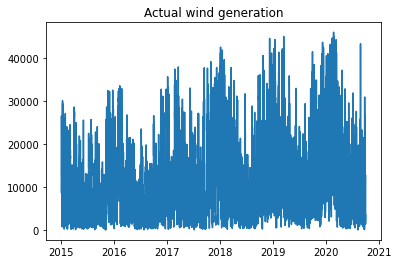

In [5]:
plt.plot(df.index, df['DE_wind_generation_actual'])
plt.title('Actual wind generation')

Text(0.5, 1.0, 'Actual solar generation')

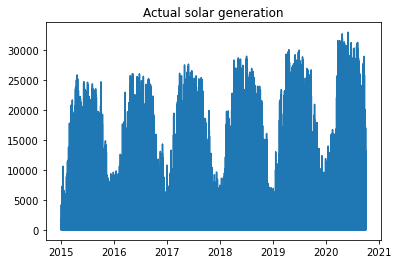

In [6]:
plt.plot(df.index, df['DE_solar_generation_actual'])
plt.title('Actual solar generation')

In [7]:
# As we see in the last two graphs , The wind and solar power aer seasonal  

production_wind_solar = df[['DE_wind_generation_actual', 'DE_solar_generation_actual']]
production_wind_solar.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2014-12-31 23:00:00+00:00,NaN,NaN
2015-01-01 00:00:00+00:00,8852.0,NaN
2015-01-01 01:00:00+00:00,9054.0,NaN
2015-01-01 02:00:00+00:00,9070.0,NaN
2015-01-01 03:00:00+00:00,9163.0,NaN


In [8]:
# Reading weather data to be combined with power data  
# https://data.open-power-system-data.org/weather_data/2020-09-16
# Metadata link : https://data.open-power-system-data.org/weather_data/2020-09-16/README.md


weather = pd.read_csv(
    r"C:\Users\Mohamed\OneDrive\Desktop\Graduation project\opsd-weather_data-2020-09-16\weather_data.csv",
                     parse_dates=[0], index_col=0)
weather.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [9]:
# resampling weather data by day to make it ready to be combined with power data  

weather_by_day = weather.groupby(weather.index).mean()
weather_by_day.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [10]:
# Meging (Solar & wind) data with (weather) data

combined = pd.merge(production_wind_solar, weather_by_day, how='left', left_index=True, right_index=True)
combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,-6.495,0.0,0.0,0.100,0.0,0.0,-13.029,0.0,...,0.0,0.610,0.0,0.0,-11.515,0.0,0.0,-8.337,0.0,0.0
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0


In [11]:
# Note | we have the solar and wind data from 01/01/2015 to 30/09/2020
#                   and temperature data from 01/01/1980 to 31/12/2019
#                   we should get the intersection between them to be able to create a powerful model
#                   The intersection between them is from 
#                                             01/01/2015 to 31/12/2019

combined = combined.loc[combined.index >= '2015-01-01 00:00:00+00:00', :]
combined = combined.loc[combined.index <= '2019-12-31 23:00:00+00:00', :]

combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
2015-01-01 04:00:00+00:00,9231.0,NaN,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0


In [12]:
combined.isnull().sum()

DE_wind_generation_actual           74
DE_solar_generation_actual         103
AT_temperature                       0
AT_radiation_direct_horizontal       0
AT_radiation_diffuse_horizontal      0
                                  ... 
SI_radiation_direct_horizontal       0
SI_radiation_diffuse_horizontal      0
SK_temperature                       0
SK_radiation_direct_horizontal       0
SK_radiation_diffuse_horizontal      0
Length: 86, dtype: int64

In [13]:
# There are some nulls found should be filled by the mean of the same column

combined["DE_wind_generation_actual" ].fillna(combined["DE_wind_generation_actual" ].mean(), inplace=True)
combined["DE_solar_generation_actual"].fillna(combined["DE_solar_generation_actual"].mean(), inplace=True)

combined.isnull().sum()

DE_wind_generation_actual          0
DE_solar_generation_actual         0
AT_temperature                     0
AT_radiation_direct_horizontal     0
AT_radiation_diffuse_horizontal    0
                                  ..
SI_radiation_direct_horizontal     0
SI_radiation_diffuse_horizontal    0
SK_temperature                     0
SK_radiation_direct_horizontal     0
SK_radiation_diffuse_horizontal    0
Length: 86, dtype: int64

In [14]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00+00:00 to 2019-12-31 23:00:00+00:00
Data columns (total 86 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DE_wind_generation_actual        43824 non-null  float64
 1   DE_solar_generation_actual       43824 non-null  float64
 2   AT_temperature                   43824 non-null  float64
 3   AT_radiation_direct_horizontal   43824 non-null  float64
 4   AT_radiation_diffuse_horizontal  43824 non-null  float64
 5   BE_temperature                   43824 non-null  float64
 6   BE_radiation_direct_horizontal   43824 non-null  float64
 7   BE_radiation_diffuse_horizontal  43824 non-null  float64
 8   BG_temperature                   43824 non-null  float64
 9   BG_radiation_direct_horizontal   43824 non-null  float64
 10  BG_radiation_diffuse_horizontal  43824 non-null  float64
 11  CH_temperature                   

In [15]:
combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,8852.0,4304.566318,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,4304.566318,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,4304.566318,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,4304.566318,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
2015-01-01 04:00:00+00:00,9231.0,4304.566318,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0


In [16]:
# print 20% of columns describtion to take some decisions

(combined.describe().T).iloc[:len(combined)//5 , :]

,count,mean,std,min,25%,50%,75%,max
DE_wind_generation_actual,43824.0,11157.555246,8686.794878,135.000,4427.75000,8745.00000,15562.250000,45085.0000
DE_solar_generation_actual,43824.0,4304.566318,6596.092670,0.000,0.00000,133.00000,6800.000000,30028.0000
AT_temperature,43824.0,8.838494,8.987517,-17.596,1.60050,8.37050,15.812250,32.6310
AT_radiation_direct_horizontal,43824.0,96.426485,179.350207,0.000,0.00000,0.53195,102.667175,869.7446
AT_radiation_diffuse_horizontal,43824.0,65.699744,89.225189,0.000,0.00000,6.95685,110.968725,403.6032
...,...,...,...,...,...,...,...,...
SI_radiation_direct_horizontal,43824.0,105.012554,194.184928,0.000,0.00000,0.40245,111.641525,895.3888
SI_radiation_diffuse_horizontal,43824.0,62.224003,85.819809,0.000,0.00000,6.22485,101.779950,408.4686
SK_temperature,43824.0,9.290873,9.742131,-18.937,1.33975,8.95250,16.948500,35.3110
SK_radiation_direct_horizontal,43824.0,97.754655,182.522103,0.000,0.00000,0.41320,101.175125,878.9789


In [17]:
# It is clear that the data should be scaled to make sure that the model will give an accurate result

X_scaler = MinMaxScaler().fit(combined.iloc[:,2:])
X_scaled = X_scaler.transform(combined.iloc[:,2:])

y_scaler = MinMaxScaler().fit(combined.iloc[:,:2])
y_scaled = y_scaler.transform(combined.iloc[:,:2])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.20, random_state=42)

In [19]:
print(f"X_train -> {X_train.shape}")
print(f"y_train -> {y_train.shape}")
print(30 * "-")
print(f"X_test  -> {X_test.shape}")
print(f"y_test  -> {y_test.shape}")

X_train -> (35059, 84)
y_train -> (35059, 2)
------------------------------
X_test  -> (8765, 84)
y_test  -> (8765, 2)


In [20]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (X_train.shape[1] ,)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.fit(X_train , y_train, epochs=50, verbose= 1,callbacks = callback)

Epoch 1/50
1096/1096 [==============================] - 2s 1ms/step - loss: 0.0186
Epoch 2/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0146
Epoch 3/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 4/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 5/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0126
Epoch 6/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0121
Epoch 7/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 8/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0115
Epoch 9/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0113
Epoch 10/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0111
Epoch 11/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0109
Epoch 12/50
1096/1096 [==============================] - 1s 1ms/step - loss: 0.0108
E

In [22]:
y_pred = model.predict(X_test)

print(f"y_test  -> {y_test.shape}")
print(f"y_pred  -> {y_pred.shape}")

274/274 [==============================] - 0s 1ms/step
y_test  -> (8765, 2)
y_pred  -> (8765, 2)


In [23]:
pd.DataFrame(y_scaler.inverse_transform(y_test)).iloc[111:122,:]

,0,1
111,37885.0,609.0
112,16804.0,0.0
113,6269.0,4316.0
114,2637.0,0.0
115,14275.0,0.0
116,18643.0,14938.0
117,9615.0,15578.0
118,3070.0,19740.0
119,19020.0,0.0
120,26802.0,0.0


In [24]:
pd.DataFrame(y_scaler.inverse_transform(y_pred)).iloc[111:122,:]

,0,1
111,26951.275391,45.597939
112,15750.406250,-8.325069
113,7963.538574,3263.835205
114,8244.597656,125.760094
115,5438.530273,142.364365
116,13769.551758,14485.548828
117,10519.398438,15305.460938
118,566.487122,17969.941406
119,11820.350586,-25.546158
120,15916.022461,-85.834618


In [25]:
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

print('Train RMSE   : %.3f ' % root_mean_squared_error(y_train, model.predict(X_train)))
print('Train MSE    : %.3f ' % mean_squared_error(y_train, model.predict(X_train)))
print('---------------------------------------------')
print('Test RMSE    : %.3f ' % root_mean_squared_error(y_test, model.predict(X_test)))
print('Test MSE     : %.3f ' % mean_squared_error(y_test, model.predict(X_test)))

1096/1096 [==============================] - 1s 1ms/step
Train RMSE   : 0.089 
1096/1096 [==============================] - 1s 1ms/step
Train MSE    : 0.008 
---------------------------------------------
274/274 [==============================] - 0s 1ms/step
Test RMSE    : 0.092 
274/274 [==============================] - 0s 1ms/step
Test MSE     : 0.008 


### DNN model

In [26]:
# Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(15, activation='relu', input_shape=(X_train.shape[1],)))

# Add the second layer
model.add(Dense(20, activation='relu'))

# Add the output layer
model.add(Dense(2))

# Compile the model
# adam = optimizers.Adam(lr=0.01)
model.compile(optimizer='adam', loss='mse')

# Fit the model

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(X_train, y_train, epochs= 50, verbose=1, validation_split=0.3 , callbacks = callback)

Epoch 1/50
767/767 [==============================] - 2s 2ms/step - loss: 0.0209 - val_loss: 0.0167
Epoch 2/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0151
Epoch 3/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 4/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 5/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 6/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 7/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 8/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 9/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 10/50
767/767 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0126

In [27]:
y_pred = model.predict(X_test)

print(f"y_test  -> {y_test.shape}")
print(f"y_pred  -> {y_pred.shape}")

274/274 [==============================] - 0s 1ms/step
y_test  -> (8765, 2)
y_pred  -> (8765, 2)


In [28]:
pd.DataFrame(y_scaler.inverse_transform(y_test)).iloc[111:122,:]

,0,1
111,37885.0,609.0
112,16804.0,0.0
113,6269.0,4316.0
114,2637.0,0.0
115,14275.0,0.0
116,18643.0,14938.0
117,9615.0,15578.0
118,3070.0,19740.0
119,19020.0,0.0
120,26802.0,0.0


In [31]:
pd.DataFrame(y_scaler.inverse_transform(y_pred)).iloc[111:122,:]

,0,1
111,27960.390625,198.971420
112,12567.521484,358.014679
113,9775.934570,4960.268066
114,12198.596680,367.918793
115,6407.331543,257.568726
116,13183.138672,18212.935547
117,6910.256348,18057.455078
118,3304.053955,18792.894531
119,12079.644531,-146.268219
120,16861.414062,277.789642


In [32]:
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

print('Train RMSE   : %.3f ' % root_mean_squared_error(y_train, model.predict(X_train)))
print('Train MSE    : %.3f ' % mean_squared_error(y_train, model.predict(X_train)))
print('---------------------------------------------')
print('Test RMSE    : %.3f ' % root_mean_squared_error(y_test, model.predict(X_test)))
print('Test MSE     : %.3f ' % mean_squared_error(y_test, model.predict(X_test)))

1096/1096 [==============================] - 1s 1ms/step
Train RMSE   : 0.104 
1096/1096 [==============================] - 1s 1ms/step
Train MSE    : 0.011 
---------------------------------------------
274/274 [==============================] - 0s 1ms/step
Test RMSE    : 0.104 
274/274 [==============================] - 0s 1ms/step
Test MSE     : 0.011 


### Bidirectional model

In [33]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test  = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [34]:
blstm_model = Sequential()
blstm_model.add(Bidirectional(LSTM(128, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],), return_sequences=True)))
blstm_model.add(Bidirectional(LSTM(64, activation='relu')))
blstm_model.add(Dense(32, activation='relu'))
blstm_model.add(Dropout(0.2))
blstm_model.add(Dense(2))

blstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = blstm_model.fit(X_train, y_train, epochs= 5, verbose= 1, callbacks= callback)

Epoch 1/5
1096/1096 [==============================] - 150s 132ms/step - loss: 0.0222
Epoch 2/5
1096/1096 [==============================] - 146s 134ms/step - loss: 0.0199
Epoch 3/5
1096/1096 [==============================] - 153s 140ms/step - loss: 0.0189
Epoch 4/5
1096/1096 [==============================] - 156s 142ms/step - loss: 0.0178
Epoch 5/5
1096/1096 [==============================] - 150s 137ms/step - loss: 0.0172


In [37]:
y_pred = blstm_model.predict(X_test)

print(f"y_test  -> {y_test.shape}")
print(f"y_pred  -> {y_pred.shape}")

274/274 [==============================] - 13s 46ms/step
y_test  -> (8765, 2)
y_pred  -> (8765, 2)


In [38]:
pd.DataFrame(y_scaler.inverse_transform(y_test)).iloc[111:122,:]

,0,1
111,37885.0,609.0
112,16804.0,0.0
113,6269.0,4316.0
114,2637.0,0.0
115,14275.0,0.0
116,18643.0,14938.0
117,9615.0,15578.0
118,3070.0,19740.0
119,19020.0,0.0
120,26802.0,0.0


In [40]:
pd.DataFrame(y_scaler.inverse_transform(y_pred)).iloc[111:122,:]

,0,1
111,17933.351562,453.672089
112,15960.533203,246.591278
113,11650.340820,6306.966797
114,11009.570312,496.877075
115,12045.768555,471.842468
116,9743.601562,14211.165039
117,8029.048340,14447.475586
118,6267.662109,17222.021484
119,11756.925781,611.210999
120,17601.923828,191.067856


In [42]:
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

print('Train RMSE   : %.3f ' % root_mean_squared_error(y_train, blstm_model.predict(X_train)))
print('Train MSE    : %.3f ' % mean_squared_error(y_train, blstm_model.predict(X_train)))
print('---------------------------------------------')
print('Test RMSE    : %.3f ' % root_mean_squared_error(y_test, blstm_model.predict(X_test)))
print('Test MSE     : %.3f ' % mean_squared_error(y_test, blstm_model.predict(X_test)))

1096/1096 [==============================] - 46s 42ms/step
Train RMSE   : 0.126 
1096/1096 [==============================] - 48s 44ms/step
Train MSE    : 0.016 
---------------------------------------------
274/274 [==============================] - 11s 42ms/step
Test RMSE    : 0.127 
274/274 [==============================] - 11s 42ms/step
Test MSE     : 0.016 
